# 01 – Data Exploration

In [1]:
import os
import random
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.windows import Window
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

LOCAL_DATA_DIR = Path("../data/raw/stacked_tiles")
BAND_MAPPING = {'S1_VV': 0, 'S1_VH': 1, 'S2_B': 2, 'S2_G': 3, 'S2_R': 4,
                'S2_N': 5, 'S2_S1': 6, 'S2_S2': 7, 'DEM': 8, 'Label': 9}
EXPECTED_BANDS = len(BAND_MAPPING)

print(f"Data dir: {LOCAL_DATA_DIR}")

Data dir: ../data/raw/stacked_tiles


In [2]:
# --- Find Files and Quick Check ---
stack_paths = sorted(list(LOCAL_DATA_DIR.glob("stack_tile_*.tif")))
print(f"Found {len(stack_paths)} files.")

valid_paths = []
if stack_paths:
    print("\nChecking basic properties (using first file) and band counts:")
    try:
        # Check first file's profile
        with rasterio.open(stack_paths[0]) as src:
            print(f"  First file ({stack_paths[0].name}):")
            print(f"    CRS: {src.crs}")
            print(f"    Size: {src.width}x{src.height}")
            print(f"    Bands: {src.count}")
            print(f"    Dtype: {src.dtypes[0]}")
            if src.count != EXPECTED_BANDS:
                 print(f"    !!! WARNING: Band count ({src.count}) doesn't match expected ({EXPECTED_BANDS}) !!!")

        # Quick check for band count consistency across all files
        incorrect_band_count = 0
        for p in stack_paths:
            try:
                with rasterio.open(p) as src_check:
                    if src_check.count != EXPECTED_BANDS:
                        incorrect_band_count += 1
                    else:
                        valid_paths.append(p) # Add to list if readable and correct count
            except Exception:
                 incorrect_band_count += 1 # Count as error if unreadable
        if incorrect_band_count > 0:
            print(f"\n!!! WARNING: {incorrect_band_count} files have incorrect band count or are unreadable !!!")
        else:
            print("\nAll readable files have the expected band count.")

    except Exception as e:
        print(f"\nError opening first file {stack_paths[0].name}: {e}")
else:
    print("\nNo files found to check.")

Found 1552 files.

Checking basic properties (using first file) and band counts:
  First file (stack_tile_1000_2019-01-01_2020.tif):
    CRS: EPSG:4326
    Size: 1114x1114
    Bands: 10
    Dtype: float32

All readable files have the expected band count.


### 1. Load and visualize RGB, S1 VV, DEM, and Label for one random valid tile.


--- Visualizing components of one random tile ---
Showing: stack_tile_1573_2019-01-01_2020.tif


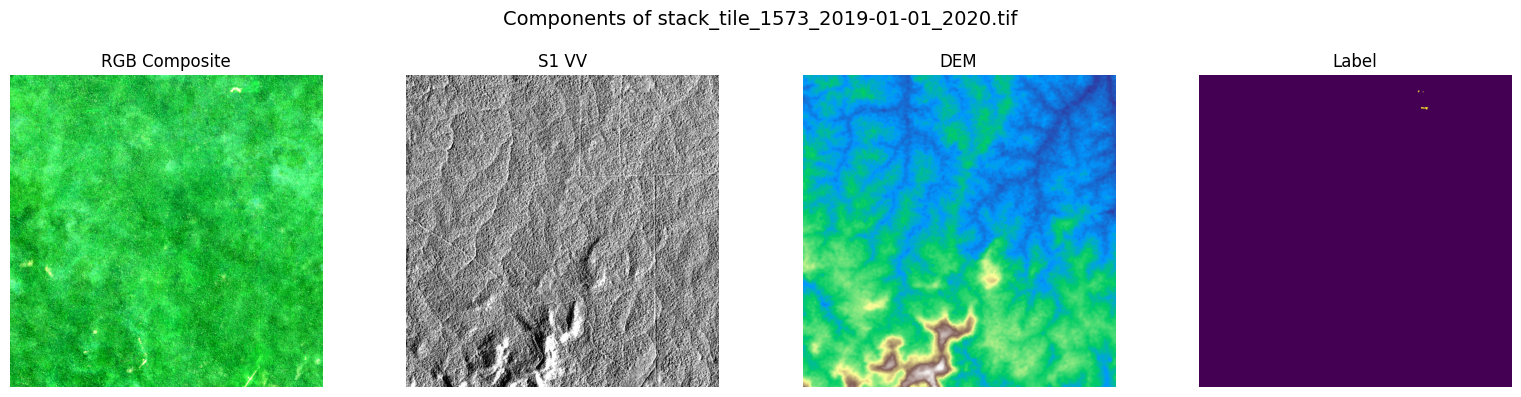

In [3]:
# --- Visualize One Random Tile ---
if valid_paths:
    print("\n--- Visualizing components of one random tile ---")
    random_path = random.choice(valid_paths)
    print(f"Showing: {random_path.name}")

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    fig.suptitle(f"Components of {random_path.name}", fontsize=14)

    try:
        with rasterio.open(random_path) as src:
            # Define indices
            s1_vv_idx, s2_r_idx, s2_g_idx, s2_b_idx, dem_idx, label_idx = (
                BAND_MAPPING['S1_VV'] + 1, BAND_MAPPING['S2_R'] + 1,
                BAND_MAPPING['S2_G'] + 1, BAND_MAPPING['S2_B'] + 1,
                BAND_MAPPING['DEM'] + 1, BAND_MAPPING['Label'] + 1
            )
            # Read needed bands
            s1_vv, s2_r, s2_g, s2_b, dem, label = (
                src.read(s1_vv_idx).astype(np.float32), src.read(s2_r_idx).astype(np.float32),
                src.read(s2_g_idx).astype(np.float32), src.read(s2_b_idx).astype(np.float32),
                src.read(dem_idx).astype(np.float32), src.read(label_idx)
            )

            # Plot RGB (simple percentile stretch)
            rgb = np.stack([s2_r, s2_g, s2_b], axis=-1)
            vmin, vmax = np.percentile(rgb[rgb>0] if np.any(rgb>0) else rgb, [2, 98])
            rgb_display = np.clip((rgb - vmin) / (vmax - vmin + 1e-6), 0, 1) # Add epsilon for safety
            axes[0].imshow(rgb_display); axes[0].set_title("RGB Composite"); axes[0].axis('off')

            # Plot S1 VV (simple percentile stretch)
            vmin_vv, vmax_vv = np.percentile(s1_vv[s1_vv > -999] if np.any(s1_vv > -999) else s1_vv, [2, 98])
            s1_vv_display = np.clip((s1_vv - vmin_vv) / (vmax_vv - vmin_vv + 1e-6), 0, 1)
            axes[1].imshow(s1_vv_display, cmap='gray'); axes[1].set_title("S1 VV"); axes[1].axis('off')

            # Plot DEM
            axes[2].imshow(dem, cmap='terrain'); axes[2].set_title("DEM"); axes[2].axis('off')

            # Plot Label
            axes[3].imshow(label, cmap='viridis', vmin=0, vmax=1); axes[3].set_title("Label"); axes[3].axis('off')

            plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust for suptitle
            plt.show()

    except Exception as e:
        print(f"Error visualizing {random_path.name}: {e}")
else:
    print("\nNo valid files to visualize.")

### 3. Plot pixel-value distributions to choose normalization strategies  


--- Plotting pixel distributions (sampled) ---
Using 5 tiles for distribution analysis.
  Label Counts (0/1): {np.float32(0.0): np.int64(6038850), np.float32(1.0): np.int64(169472)}


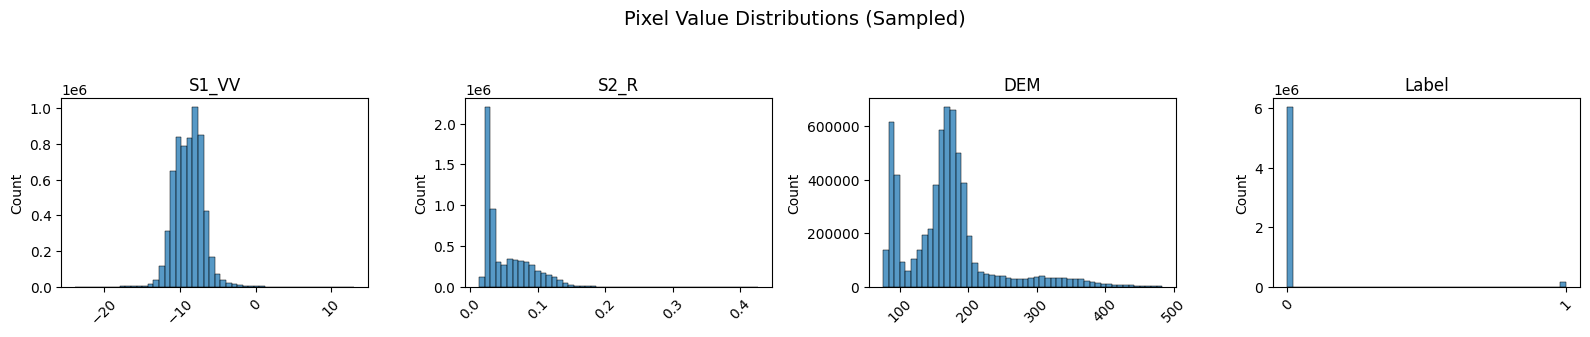

In [4]:
# --- Plot Distributions (Sample) ---
if valid_paths:
    print("\n--- Plotting pixel distributions (sampled) ---")
    n_dist_samples = min(5, len(valid_paths)) # Use fewer samples for speed
    dist_sample_paths = random.sample(valid_paths, n_dist_samples)
    print(f"Using {n_dist_samples} tiles for distribution analysis.")

    bands_for_dist = ['S1_VV', 'S2_R', 'DEM', 'Label'] # Fewer bands
    band_values = {name: [] for name in bands_for_dist}

    for path in dist_sample_paths:
        try:
            with rasterio.open(path) as src:
                for band_name in bands_for_dist:
                    data = src.read(BAND_MAPPING[band_name] + 1).astype(np.float32).flatten()
                    band_values[band_name].append(data) # Filter nodata later if needed
        except Exception as e:
            print(f"Skipping {path.name} for distribution analysis: {e}")

    # Concatenate and Plot
    fig_dist, axes_dist = plt.subplots(1, len(bands_for_dist), figsize=(4 * len(bands_for_dist), 3.5))
    if len(bands_for_dist) == 1: axes_dist = [axes_dist] # Make iterable
    fig_dist.suptitle("Pixel Value Distributions (Sampled)", fontsize=14)

    for i, band_name in enumerate(bands_for_dist):
        ax = axes_dist[i]
        if band_values[band_name]:
            vals = np.concatenate(band_values[band_name])
            # Simple plot - consider filtering extreme outliers if needed
            sns.histplot(vals, bins=50, ax=ax, kde=False)
            ax.set_title(band_name)
            if band_name == 'Label':
                unique, counts = np.unique(vals, return_counts=True)
                ax.set_xticks([0, 1]) # Ensure ticks are at 0 and 1
                print(f"  Label Counts (0/1): {dict(zip(unique, counts))}")
            ax.tick_params(axis='x', rotation=45)
        else:
            ax.set_title(f"{band_name}\n(No Data)"); ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()
    del band_values # Clear memory

else:
    print("\nNo valid files for distribution analysis.")

### 5. Displaying a random 256×256 crop from one tile  



--- Displaying grouped channels from a random 256x256 crop (color composites and single bands) ---
Using source file: stack_tile_464_2019-01-01_2020.tif


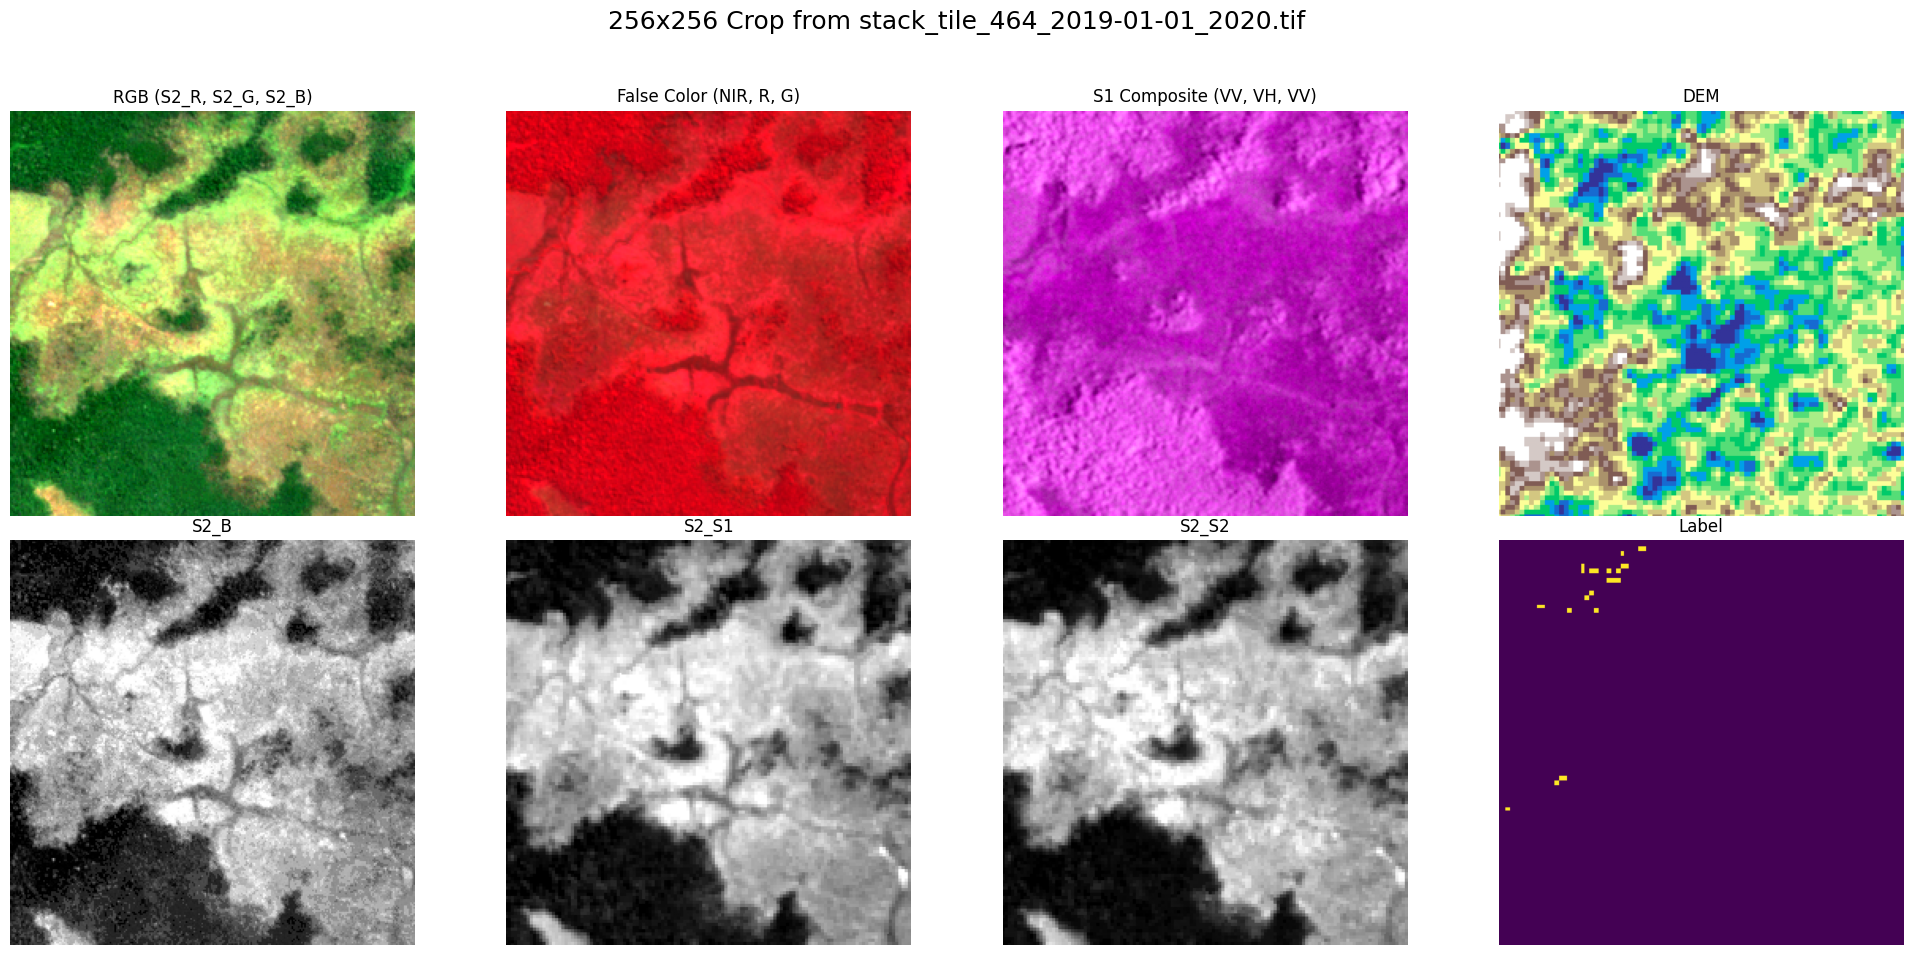

In [8]:
# --- Visualize Random Crop: All Channels in Visually Pleasant Way (Grouped by Type) ---
if valid_paths:
    print("\n--- Displaying grouped channels from a random 256x256 crop (color composites and single bands) ---")
    crop_size = 256
    random_path = random.choice(valid_paths)
    print(f"Using source file: {random_path.name}")

    try:
        with rasterio.open(random_path) as src:
            if src.width < crop_size or src.height < crop_size:
                print(f"Skipping crop: Image {src.width}x{src.height} smaller than {crop_size}x{crop_size}")
            else:
                # Get random window
                col_off = random.randint(0, src.width - crop_size)
                row_off = random.randint(0, src.height - crop_size)
                win = Window(col_off, row_off, crop_size, crop_size)

                # Read, transpose
                crop_stack = src.read(window=win).transpose(1, 2, 0).astype(np.float32)
                idx = BAND_MAPPING

                # --- Color composites ---
                # RGB (S2_R, S2_G, S2_B)
                rgb = crop_stack[:, :, [idx['S2_R'], idx['S2_G'], idx['S2_B']]]
                vmin_rgb, vmax_rgb = np.percentile(rgb[rgb > 0] if np.any(rgb > 0) else rgb, [2, 98])
                rgb_disp = np.clip((rgb - vmin_rgb) / (vmax_rgb - vmin_rgb + 1e-6), 0, 1)

                # False color (NIR, R, G)
                false_rgb = crop_stack[:, :, [idx['S2_N'], idx['S2_R'], idx['S2_G']]]
                vmin_f, vmax_f = np.percentile(false_rgb[false_rgb > 0] if np.any(false_rgb > 0) else false_rgb, [2, 98])
                false_rgb_disp = np.clip((false_rgb - vmin_f) / (vmax_f - vmin_f + 1e-6), 0, 1)

                # S1 composite (VV, VH, VV)
                s1_vv = crop_stack[:, :, idx['S1_VV']]
                s1_vh = crop_stack[:, :, idx['S1_VH']]
                s1_rgb = np.stack([s1_vv, s1_vh, s1_vv], axis=-1)
                vmin_s1, vmax_s1 = np.percentile(s1_rgb, [2, 98])
                s1_rgb_disp = np.clip((s1_rgb - vmin_s1) / (vmax_s1 - vmin_s1 + 1e-6), 0, 1)

                # --- Single bands ---
                def scale_band(band):
                    vmin, vmax = np.percentile(band, [2, 98])
                    return np.clip((band - vmin) / (vmax - vmin + 1e-6), 0, 1)

                dem_disp = scale_band(crop_stack[:, :, idx['DEM']])
                s2_s1_disp = scale_band(crop_stack[:, :, idx['S2_S1']])
                s2_s2_disp = scale_band(crop_stack[:, :, idx['S2_S2']])
                s2_b_disp = scale_band(crop_stack[:, :, idx['S2_B']])

                # Label
                label = crop_stack[:, :, idx['Label']]

                # --- Plot: 2 rows x 4 columns ---
                fig, axes = plt.subplots(2, 4, figsize=(20, 10))
                fig.suptitle(f"{crop_size}x{crop_size} Crop from {random_path.name}", fontsize=18)

                # Row 1: RGB, False Color, S1 Composite, DEM
                axes[0, 0].imshow(rgb_disp)
                axes[0, 0].set_title("RGB (S2_R, S2_G, S2_B)")
                axes[0, 0].axis('off')

                axes[0, 1].imshow(false_rgb_disp)
                axes[0, 1].set_title("False Color (NIR, R, G)")
                axes[0, 1].axis('off')

                axes[0, 2].imshow(s1_rgb_disp)
                axes[0, 2].set_title("S1 Composite (VV, VH, VV)")
                axes[0, 2].axis('off')

                axes[0, 3].imshow(dem_disp, cmap='terrain')
                axes[0, 3].set_title("DEM")
                axes[0, 3].axis('off')

                # Row 2: S2_B, S2_S1, S2_S2, Label
                axes[1, 0].imshow(s2_b_disp, cmap='gray')
                axes[1, 0].set_title("S2_B")
                axes[1, 0].axis('off')

                axes[1, 1].imshow(s2_s1_disp, cmap='gray')
                axes[1, 1].set_title("S2_S1")
                axes[1, 1].axis('off')

                axes[1, 2].imshow(s2_s2_disp, cmap='gray')
                axes[1, 2].set_title("S2_S2")
                axes[1, 2].axis('off')

                axes[1, 3].imshow(label, cmap='viridis', vmin=0, vmax=1)
                axes[1, 3].set_title("Label")
                axes[1, 3].axis('off')

                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                plt.show()

    except Exception as e:
        print(f"Error processing crop from {random_path.name}: {e}")
else:
    print("\nNo valid files to visualize crop.")

### **10 Input Channels (from BAND_MAPPING):**
1. **S1_VV**  (Sentinel-1 SAR, VV polarization)
2. **S1_VH**  (Sentinel-1 SAR, VH polarization)
3. **S2_B**   (Sentinel-2 Blue)
4. **S2_G**   (Sentinel-2 Green)
5. **S2_R**   (Sentinel-2 Red)
6. **S2_N**   (Sentinel-2 Near-Infrared)
7. **S2_S1**  (Sentinel-2 Shortwave Infrared 1)
8. **S2_S2**  (Sentinel-2 Shortwave Infrared 2)
9. **DEM**    (Digital Elevation Model)
10. **Label** (Ground truth, e.g., deforestation mask)

---

### **How They Are Visualized in the 2x4 Grid:**

#### **Row 1:**
1. **RGB (S2_R, S2_G, S2_B)**  
   - **Channels used:** S2_R, S2_G, S2_B  
   - **Explanation:** These three channels are combined to form a true-color image, showing what a human would see.

2. **False Color (S2_N, S2_R, S2_G)**  
   - **Channels used:** S2_N, S2_R, S2_G  
   - **Explanation:** This composite highlights vegetation and other features by using NIR as red, Red as green, and Green as blue.

3. **S1 Composite (S1_VV, S1_VH, S1_VV)**  
   - **Channels used:** S1_VV (twice), S1_VH  
   - **Explanation:** SAR channels are mapped to RGB for visualization: VV to Red & Blue, VH to Green.

4. **DEM**  
   - **Channel used:** DEM  
   - **Explanation:** The elevation data is shown with a terrain colormap.

#### **Row 2:**
5. **S2_B**  
   - **Channel used:** S2_B  
   - **Explanation:** Blue band shown as grayscale.

6. **S2_S1**  
   - **Channel used:** S2_S1  
   - **Explanation:** Shortwave Infrared 1, grayscale.

7. **S2_S2**  
   - **Channel used:** S2_S2  
   - **Explanation:** Shortwave Infrared 2, grayscale.

8. **Label**  
   - **Channel used:** Label  
   - **Explanation:** Ground truth mask, shown with a color map.

---

### **Summary Table**

| Subplot Title         | Channels Used         | Input Index/Indices | Notes                                 |
|-----------------------|----------------------|--------------------|---------------------------------------|
| RGB                   | S2_R, S2_G, S2_B     | 4, 3, 2            | True-color composite                  |
| False Color           | S2_N, S2_R, S2_G     | 5, 4, 3            | NIR composite, highlights vegetation  |
| S1 Composite          | S1_VV, S1_VH         | 0, 1               | SAR bands mapped to RGB               |
| DEM                   | DEM                  | 8                  | Elevation, terrain colormap           |
| S2_B                  | S2_B                 | 2                  | Blue band, grayscale                  |
| S2_S1                 | S2_S1                | 6                  | SWIR1, grayscale                      |
| S2_S2                 | S2_S2                | 7                  | SWIR2, grayscale                      |
| Label                 | Label                | 9                  | Ground truth, color map               |

---

**How does this cover all 10 inputs?**  
- **Every input channel is visualized at least once:**  
  - The three RGB bands are combined for the true-color image.
  - NIR, Red, and Green are combined for the false color.
  - S1_VV and S1_VH are combined for the SAR composite.
  - DEM, S2_B, S2_S1, S2_S2, and Label are shown individually.